References : https://github.com/NikolasEnt/Vehicle-Detection-and-Tracking/blob/master/VehicheDetect.ipynb

# Data Processing

Data: 

https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip

https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

In [1]:
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

--2019-05-20 04:22:07--  https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68553005 (65M) [application/zip]
Saving to: ‘vehicles.zip’

vehicles.zip        100%[===================>]  65.38M  68.4MB/s    in 1.0s    

2019-05-20 04:22:08 (68.4 MB/s) - ‘vehicles.zip’ saved [68553005/68553005]

--2019-05-20 04:22:12--  https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57599296 (55M) [application/zip]
Saving to: ‘non-vehicles.zip’

non-vehicles.zip    100%[===================>]  54.93M  65.8MB/s    in 0.8s    

2019-05-20 04:22:13 (65.8 MB/s) - ‘non-vehicles.zi

In [0]:
!mkdir data
!unzip -d data/ vehicles.zip
!unzip -d data/ non-vehicles.zip

In [0]:
# data_path_vehicles = 'data/*/*'
# data_path_non_vehicles = 'data/*/*'

data_path_vehicles = 'data/vehicles/*/*'
data_path_non_vehicles = 'data/non-vehicles/*/*'

In [0]:
import glob

In [0]:
file_paths = glob.glob(data_path_vehicles)
file_paths.extend(glob.glob(data_path_non_vehicles))

In [50]:
file_paths[0:5]

['data/vehicles/GTI_Far/image0717.png',
 'data/vehicles/GTI_Far/image0113.png',
 'data/vehicles/GTI_Far/image0529.png',
 'data/vehicles/GTI_Far/image0305.png',
 'data/vehicles/GTI_Far/image0804.png']

In [51]:
np.random.seed(0)
np.random.shuffle(file_paths)
file_paths[:5]

['data/vehicles/GTI_Left/image0892.png',
 'data/vehicles/KITTI_extracted/4771.png',
 'data/non-vehicles/Extras/extra653.png',
 'data/vehicles/GTI_Left/image0424.png',
 'data/vehicles/GTI_Left/image0572.png']

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

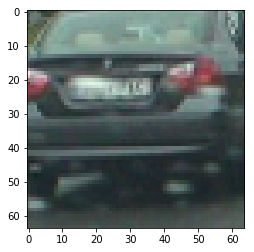

In [52]:
img = mpimg.imread(file_paths[0])
img_plot = plt.imshow(img)
plt.show()

In [53]:
file_paths[0].split('/')[-3]

'vehicles'

In [0]:
import cv2
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [0]:
import numpy as np

In [0]:
data = []
labels = []

for i in file_paths:
  try:
    img = cv2.imread(i)
    img = img_to_array(img)
    data.append(img)
    if i.split('/')[-3] == 'vehicles':
      labels.append(1)
    else:
      labels.append(0)
  except Exception as e:
    print(e)
    print(i)
    break

data = np.array(data, dtype=np.float32) / 255.0 # normalize the data
labels = to_categorical(np.asarray(labels)) # one hot encoding

In [56]:
data.shape, labels.shape

((17760, 64, 64, 3), (17760, 2))

In [0]:
img = img_to_array(cv2.imread('data/vehicles/KITTI_extracted/791.png'))

In [35]:
img.shape

(64, 64, 3)

In [0]:
# data augmentation

def data_augmentation():
  """Function for augmenting data."""
  aug = ImageDataGenerator(
      rotation_range=90,
      width_shift_range=0.1,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode="nearest"
  )
  return aug

In [0]:
aug = data_augmentation()

In [59]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14208, 64, 64, 3), (14208, 2), (3552, 64, 64, 3), (3552, 2))

In [77]:
# validation data

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((12787, 64, 64, 3), (12787, 2), (1421, 64, 64, 3), (1421, 2))

# Model

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras import backend as K
import keras

In [61]:
x_train.shape[1:]

(64, 64, 3)

Lets try LeNet 

In [0]:
def build_model(num_classes):
  """Function to build the model"""
  
  input_shape = x_train.shape[1:]
  
  # start
  model = Sequential()
  
  # model block 1 
  model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # model block 2
  model.add(Conv2D(50, (5, 5), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # FC layer
  model.add(Flatten())
  model.add(Dense(120))
  model.add(Activation("relu"))
  model.add(Dense(84))
  model.add(Activation("relu"))
  
  # classifier layer
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))
  
  return model

In [66]:
model = build_model(2)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 20)        1520      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
flat

In [0]:
epochs = 50
init_lr = 1e-3
batch_ = 32

In [0]:
opt = keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)

In [0]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [0]:
import matplotlib
matplotlib.use('Agg')
import random

In [0]:
def plot_summary(H, epochs):
  """Function to plot the training summary."""
  plt.style.use("ggplot")
  plt.figure(figsize=(9, 6))
  N = epochs
  
  for i in zip(['loss', 'val_loss', 'acc', 'val_acc'], ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
    plt.plot(np.arange(0, N), H.history[i[0]], label=i[1])
  plt.title("Training loss and Accuracy")
  plt.xlabel('Epoch #')
  plt.ylabel('Loss / Accuracy')
  plt.legend(loc="lower left")
  plt.show()

In [74]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9735982720116108607
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13651834321615697287
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6995250680664438574
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17545920979485498495
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [76]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Training

In [78]:
H = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // batch_,
    epochs=epochs,
    verbose=2
)

Epoch 1/50
 - 14s - loss: 0.1722 - acc: 0.9312 - val_loss: 0.1559 - val_acc: 0.9423
Epoch 2/50
 - 13s - loss: 0.1240 - acc: 0.9529 - val_loss: 0.1541 - val_acc: 0.9402
Epoch 3/50
 - 13s - loss: 0.1350 - acc: 0.9465 - val_loss: 0.1188 - val_acc: 0.9557
Epoch 4/50
 - 13s - loss: 0.0812 - acc: 0.9714 - val_loss: 0.1010 - val_acc: 0.9648
Epoch 5/50
 - 14s - loss: 0.0948 - acc: 0.9662 - val_loss: 0.1126 - val_acc: 0.9606
Epoch 6/50
 - 13s - loss: 0.0692 - acc: 0.9746 - val_loss: 0.0506 - val_acc: 0.9817
Epoch 7/50
 - 13s - loss: 0.0722 - acc: 0.9751 - val_loss: 0.1259 - val_acc: 0.9472
Epoch 8/50
 - 13s - loss: 0.0653 - acc: 0.9763 - val_loss: 0.0545 - val_acc: 0.9817
Epoch 9/50
 - 13s - loss: 0.0587 - acc: 0.9787 - val_loss: 0.0377 - val_acc: 0.9923
Epoch 10/50
 - 13s - loss: 0.0569 - acc: 0.9801 - val_loss: 0.0525 - val_acc: 0.9838
Epoch 11/50
 - 15s - loss: 0.0539 - acc: 0.9803 - val_loss: 0.0339 - val_acc: 0.9887
Epoch 12/50
 - 13s - loss: 0.0489 - acc: 0.9823 - val_loss: 0.0784 - val_a

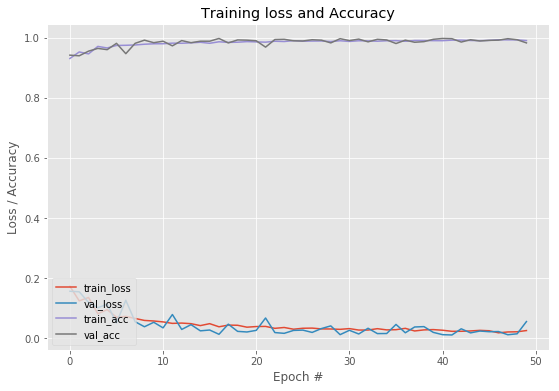

In [81]:
plot_summary(H, epochs)

In [82]:
model.evaluate(x_test, y_test, verbose=2)

[0.06259910366157079, 0.9805743243243243]

#Testing

In [83]:
!wget https://images.sftcdn.net/images/t_app-logo-l,f_auto,dpr_auto/p/82c49248-362d-11e7-9f60-f938ceaa2208/1459941345/police-car-driving-training-icon.png

--2019-05-20 06:00:02--  https://images.sftcdn.net/images/t_app-logo-l,f_auto,dpr_auto/p/82c49248-362d-11e7-9f60-f938ceaa2208/1459941345/police-car-driving-training-icon.png
Resolving images.sftcdn.net (images.sftcdn.net)... 23.45.188.68, 2600:1407:16:19b::49f, 2600:1407:16:1a3::49f
Connecting to images.sftcdn.net (images.sftcdn.net)|23.45.188.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9133 (8.9K) [image/png]
Saving to: ‘police-car-driving-training-icon.png’

police-car-driving- 100%[===================>]   8.92K  --.-KB/s    in 0s      

2019-05-20 06:00:03 (165 MB/s) - ‘police-car-driving-training-icon.png’ saved [9133/9133]



In [84]:
!ls

data		  police-car-driving-training-icon.png	vehicles.zip
non-vehicles.zip  sample_data


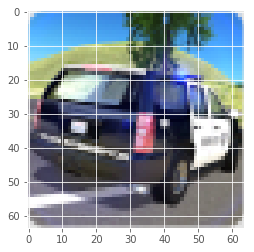

In [86]:
img = mpimg.imread('police-car-driving-training-icon.png')
imgplot = plt.imshow(img)
plt.show()

In [87]:
img = cv2.imread('police-car-driving-training-icon.png')
img = img_to_array(img)

test_data = [img]
test_data =  np.array(test_data, dtype=np.float32) / 255.0
test_data.shape


(1, 64, 64, 3)

In [0]:
prediction = model.predict(test_data)

In [106]:
np.argmax(prediction)

1

It predicts well

# Existing Functions

In [0]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [0]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [0]:


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, model):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
      #3) Extract the test window from original image
      test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
      # 4) normalize the image
      test_img = img_to_array(test_img)
      test = [test_img]
      test = np.array(test, dtype=np.float32) / 255.0
      #5) Predict using your classifier
      prediction = model.predict(test)
      #6) If positive (prediction == 1) then save the window
      if np.argmax(prediction) == 1:
          on_windows.append(window)
    #7) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')



In [91]:
!wget https://d2v9y0dukr6mq2.cloudfront.net/video/thumbnail/WUS5VgH/vehicles-on-road-cars-driving-on-highway-with-mountain-in-background-drivers-on-freeway_nkw-kwqv__F0000.png

--2019-05-20 06:09:19--  https://d2v9y0dukr6mq2.cloudfront.net/video/thumbnail/WUS5VgH/vehicles-on-road-cars-driving-on-highway-with-mountain-in-background-drivers-on-freeway_nkw-kwqv__F0000.png
Resolving d2v9y0dukr6mq2.cloudfront.net (d2v9y0dukr6mq2.cloudfront.net)... 99.84.240.47, 99.84.240.201, 99.84.240.73, ...
Connecting to d2v9y0dukr6mq2.cloudfront.net (d2v9y0dukr6mq2.cloudfront.net)|99.84.240.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010035 (1.9M) [application/octet-stream]
Saving to: ‘vehicles-on-road-cars-driving-on-highway-with-mountain-in-background-drivers-on-freeway_nkw-kwqv__F0000.png’

vehicles-on-road-ca 100%[===================>]   1.92M  3.72MB/s    in 0.5s    

2019-05-20 06:09:20 (3.72 MB/s) - ‘vehicles-on-road-cars-driving-on-highway-with-mountain-in-background-drivers-on-freeway_nkw-kwqv__F0000.png’ saved [2010035/2010035]



lets try sliding and searching

In [0]:
test_path = 'vehicles-on-road-cars-driving-on-highway-with-mountain-in-background-drivers-on-freeway_nkw-kwqv__F0000.png'

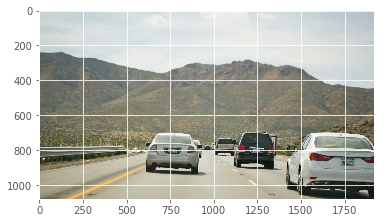

In [95]:
img = mpimg.imread(test_path)
plot_img = plt.imshow(img)
plt.show()

In [0]:
img = cv2.imread(test_path)
draw_img = np.copy(img)

In [98]:
img.shape, draw_img.shape

((1080, 1920, 3), (1080, 1920, 3))

In [0]:
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[600, 1000], xy_window=(250, 250), xy_overlap=(0.5, 0.5))

In [0]:
hot_windows = search_windows(img, windows, model)

In [128]:
len(hot_windows)

17

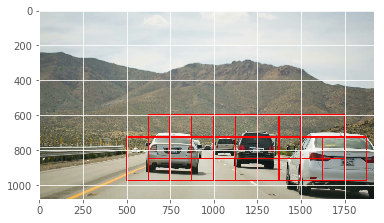

In [129]:
window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=5)
show_img(window_img)